In [12]:
import geopandas as gpd
import pandas as pd
import numpy as np
from libpysal.graph import read_parquet

In [2]:
furl = "../data/GHS_BUILT_S_E2018_GLOBE_R2023A_54009_10_V1_0_R4_C20.tif"

In [3]:
import rioxarray
bus = rioxarray.open_rasterio(furl).squeeze()

In [4]:
bus

<xarray.DataArray (y: 100000, x: 100000)> Size: 10GB
[10000000000 values with dtype=uint8]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 800kB 9.59e+05 9.59e+05 ... 1.959e+06 1.959e+06
  * y            (y) float64 800kB 6e+06 6e+06 6e+06 6e+06 ... 5e+06 5e+06 5e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     255
    scale_factor:   1.0
    add_offset:     0.0

In [5]:
def morphotopes_to_etcs(region_id, etcs=True, model_params='_100_0_None_None_False'):


    if etcs:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

    else:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')
        
    etcs['label'] = -1
    
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

    morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
    etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
    etcs['morph'] = str(region_id) + '_' + '-1'
    etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values
    return etcs

In [6]:
region_id = 69333

In [7]:
# etcs = morphotopes_to_etcs(region_id)

In [52]:
# etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/enclosures/enclosure_{region_id}.parquet')

In [13]:
etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

In [14]:
etcs

,enclosure_index,geometry
-4256,14,"POLYGON ((4640686.945 3009607.8, 4640681.609 3..."
-4255,15,"POLYGON ((4640686.945 3009607.8, 4640688.388 3..."
-4254,16,"POLYGON ((4640688.388 3009601.027, 4640686.945..."
-4253,18,"POLYGON ((4640700.906 3009598.885, 4640701.303..."
-4252,39,"POLYGON ((4695707.543 2956416.213, 4695708.161..."
...,...,...
447721,2298,"POLYGON ((4642330.787 3007527.177, 4642321.162..."
447722,1603,"POLYGON ((4638128.017 2999990.909, 4638128.702..."
447723,24712,"POLYGON ((4651389.964 3010344.33, 4651391.023 ..."
447724,24810,"POLYGON ((4647555.712 3009579.701, 4647556.613..."


In [15]:
bgraph = read_parquet(f'/data/uscuni-ulce/processed_data/neigh_graphs/building_graph_{region_id}.parquet')

In [33]:
component_labels = bgraph.component_labels

In [34]:
%%time
dissolved_tess_cells = etcs.loc[component_labels.index, :].dissolve(component_labels.values, as_index=True)
dissolved_tess_cells = dissolved_tess_cells.geometry

CPU times: user 10.9 s, sys: 129 ms, total: 11 s
Wall time: 11 s


In [35]:
empty_tess_cells = etcs[etcs.index < 0].geometry

In [36]:
etcs_to_rasterize = pd.concat((empty_tess_cells, dissolved_tess_cells)).to_frame()

In [37]:
etcs_to_rasterize['num_index'] = np.arange(1, etcs_to_rasterize.shape[0] + 1)

In [38]:
bgraph[130516]

neighbor
130516    1
237355    1
Name: weight, dtype: int64

In [39]:
bgraph[237355]

neighbor
130516    1
237355    1
Name: weight, dtype: int64

In [40]:
component_labels[component_labels == 111166]

focal
130516    111166
237355    111166
Name: component labels, dtype: int32

In [44]:
etcs_utm = etcs_to_rasterize.to_crs(bus.rio.crs)

In [45]:
geom = etcs_utm.reset_index()[['geometry', 'num_index']].values.tolist()

In [46]:
import shapely

In [47]:
shapely.GeometryCollection(etcs_utm.geometry.values).bounds

(1056322.2981511406, 5824057.637521706, 1175687.5972397642, 5913205.059116768)

In [48]:
minx, miny, maxx, maxy = shapely.GeometryCollection(etcs_utm.geometry.values).bounds

In [49]:
### read only partial data
test = rioxarray.open_rasterio(
    filename=furl, 
    chunks='auto', 
    parse_coordinates=False,
    masked=True
).rio.clip_box(minx, miny, maxx, maxy)

In [50]:
# geom2 = [[g,i] for g, i in geom if i == shp_id]

In [51]:
from rasterio import features
fields_rasterized = features.rasterize(geom, out_shape=(test.shape[1], test.shape[2]), transform=test.rio.transform())

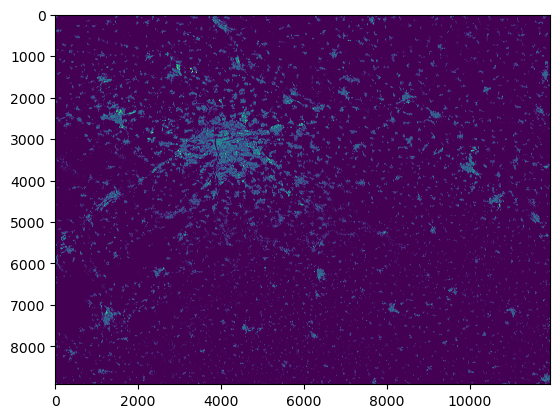

In [52]:
import matplotlib.pyplot as plt
plt.imshow(test.data[0])

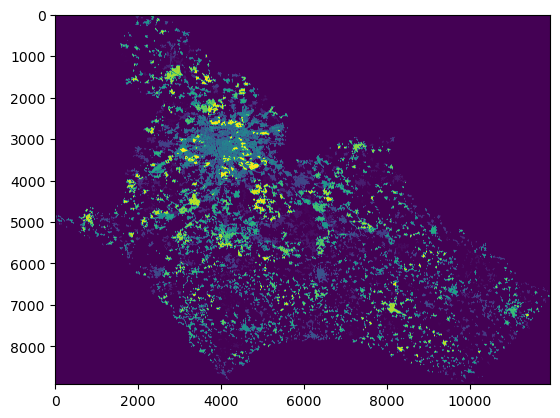

In [53]:
plt.imshow(fields_rasterized)

In [54]:
import shapely
from rasterio import transform

In [55]:
# vector_shapes = []


# for i, r in enumerate(shapes):
#     if i > 10:
#         break
#     i += 1

#     idxs = np.array(r[0]['coordinates'][0], dtype=np.int32)


#     xs, ys = transformer.xy(idxs[:, 1], idxs[:, 0], offset='ul')
#     coords = np.vstack((xs, ys)).T
#     shp = shapely.Polygon(coords)

#     unique_idxs = np.unique(idxs, axis=0)
#     bu_sum = test[0, unique_idxs[:, 1], unique_idxs[:, 0]].sum().values

    
#     # with transform set
#     # shp = shapely.Polygon(np.array(r[0]['coordinates'][0])[:, [0,1]])


#     shp_id = r[1]
#     vector_shapes.append([shp, shp_id, bu_sum])

In [56]:
# gdf = gpd.GeoDataFrame(vector_shapes, columns = ['geometry', 'id', 'bu_sum'], crs = test.rio.crs)
# gdf = gdf.merge(etcs.reset_index()[['index', 'num_index']], left_on='id', right_on='num_index')

# m = etcs.loc[gdf['index'].values].explore(color='red')
# m = gdf.explore(m=m)
# m

In [57]:
ebua = pd.Series(test.as_numpy().values.flatten()).groupby(fields_rasterized.flatten()).agg(['sum', 'describe'])
ebua.columns = ebua.columns.get_level_values(1)
ebua.columns = ['sum'] + ebua.columns[1:].tolist()

In [58]:
etcs_to_rasterize.num_index

-4256           1
-4255           2
-4254           3
-4253           4
-4252           5
            ...  
 363718    367975
 363719    367976
 363720    367977
 363721    367978
 363722    367979
Name: num_index, Length: 367979, dtype: int64

In [59]:
etcs = etcs_to_rasterize.merge(ebua, left_on='num_index', right_index=True, how='left')

In [60]:
# ## if not merged...
# etcs = etcs.merge(ebua, left_on='num_index', right_index=True, how='left')

In [61]:
etcs = etcs.fillna(0)

In [62]:
etcs['ratio'] = etcs['sum'] / etcs.area
etcs['area'] = etcs.area

In [63]:
(etcs['sum'] > etcs['area']).sum()

np.int64(182)

In [64]:
etcs['garea'] = etcs['area'] - etcs['sum']

In [65]:
etcs['garea_ratio'] = etcs['garea'] / etcs['area']

In [66]:
buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')

In [67]:
buildings = buildings.dissolve(component_labels)

In [68]:
etcs['barea'] = buildings.area
etcs['barea'] = etcs['barea'].fillna(0)

etcs['bperi'] = buildings.length
etcs['bperi'] = etcs['bperi'].fillna(0)

In [69]:
lrg = (etcs['sum'] < etcs['barea']) & (etcs.index >= 0)

In [70]:
### total builtup surface should be atleast the etcs building area
etcs.loc[lrg, 'sum'] = etcs.loc[lrg, 'barea']

/tmp/ipykernel_235494/2639543989.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 137.30143444  385.56383893  120.78673033 ...  653.1006364   878.98909485
 2404.94597037]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  etcs.loc[lrg, 'sum'] = etcs.loc[lrg, 'barea']


In [71]:
etcs['nbs'] = etcs['sum'] - etcs['barea']

In [72]:
etcs['bratio'] = etcs['sum'] / etcs['barea']

In [113]:
graph_dir = '/data/uscuni-ulce/processed_data/neigh_graphs/'
from libpysal.graph import read_parquet

In [114]:
graph = read_parquet(graph_dir + f'tessellation_graph_{region_id}.parquet')

In [115]:
graph3 = graph.higher_order(k=3, lower_order=True, diagonal=True)

In [40]:
##sums
etcs['nbs3'] = graph3.lag(etcs['nbs'].values)
etcs['ratio3'] = graph3.lag(etcs['ratio'].values)

In [41]:
## means
graph3.transform = 'R'
etcs['nbs3_m'] = graph3.lag(etcs['nbs'].values)
etcs['ratio3_m'] = graph3.lag(etcs['ratio'].values)

In [42]:
etcs['75%_m'] = graph3.lag(etcs['75%'].values)

In [73]:
from core.cluster_validation import generate_detailed_clusters
morphotopes = generate_detailed_clusters(etcs, path = '/data/uscuni-ulce/validation/val_morphotopes/prague_morphotopes.pq')
morphotope_etcs = etcs.loc[morphotopes.index]
morphotope_etcs['mlabel'] = morphotopes.values

types = pd.Series([0,0,0, 1,1, 2,2,2,2, 3,3], index=[8,134,14, 18,31, 7,5,37,36, 57,58])
types = types.replace({0: 'houses', 1: 'grid', 2: 'apartment blocks', 3: 'industry'})
morphotope_etcs = morphotope_etcs[morphotope_etcs['mlabel'].isin(types.index)]
morphotope_etcs['types'] = morphotope_etcs['mlabel'].map(lambda x: types.loc[x])



In [80]:
# morphotope_etcs.explore(prefer_canvas=True, tiles='cartodb.Positron', column='sum')

In [87]:
res = morphotope_etcs.iloc[:, 2:-1].groupby(morphotope_etcs['types']).mean()
res.style.background_gradient(axis=0, cmap="BuGn")

,sum,count,mean,std,min,25%,50%,75%,max,ratio,area,garea,garea_ratio,barea,bperi,nbs,bratio,mlabel
types,,,,,,,,,,,,,,,,,,
apartment blocks,2779.661843,106.882184,28.250598,24.516143,1.833333,8.995690,19.765805,43.250718,85.364943,0.282461,10701.409586,7937.257287,0.717539,1576.254390,240.971784,1203.407453,2.288913,17.781609
grid,3491.556024,90.097744,31.866019,18.969303,6.293233,17.321429,27.259398,45.906015,72.406015,0.319062,9019.958084,5848.755076,0.680938,3182.083647,531.905216,309.472377,3.573927,26.699248
houses,445.257441,15.621333,29.982414,16.211799,11.853333,18.483333,26.669778,39.271111,58.364444,0.300577,1564.808228,1126.733561,0.699423,240.244074,70.936587,205.013367,2.806775,27.818667
industry,2825.489469,78.133595,34.340079,22.261903,7.379175,16.775540,29.483301,49.085462,79.836935,0.344832,7821.200829,5038.996507,0.655168,1713.367925,160.915762,1112.121543,7.347082,57.754420


In [69]:
plotting = etcs[etcs.index >= 0]

In [42]:
import lonboard
from sidecar import Sidecar

In [43]:
layer = lonboard.SolidPolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [44]:
sc = Sidecar(title='tess')
m = lonboard.Map(layer)
with sc:
    display(m)

In [45]:
etcs.columns

Index(['enclosure_index', 'geometry', 'label', 'morph', 'num_index', 'sum',
       'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'ratio',
       'area', 'barea', 'bperi', 'nbs', 'nbs3', 'ratio3', 'nbs3_m', 'ratio3_m',
       '75%_m', 'bratio'],
      dtype='object')

In [70]:
column = 'garea'

In [71]:
from lonboard.colormap import apply_continuous_cmap
import matplotlib as mpl
from mapclassify import classify

# classifier = classify(plotting[column], 'quantiles', k=100)
# normalizer = mpl.colors.Normalize(0, classifier.bins.shape[0])
# vals = normalizer(classifier.yb)
# layer.get_fill_color = apply_continuous_cmap(vals, mpl.colormaps['viridis'])

In [73]:
from core.cluster_validation import get_color
a = plotting[column]
a = StandardScaler().fit_transform(plotting[column].to_frame())[:, 0]
# quintiles = np.nanpercentile(a, np.arange(1, 100, 1).tolist() + [99.5, 99.9])    
quintiles = np.nanpercentile(a, np.arange(1, 100, 10).tolist())    
vals = np.searchsorted(quintiles, a)
layer.get_fill_color = get_color(vals)

In [56]:
from sklearn.preprocessing import StandardScaler

In [ ]:
### ratio of larger buildings around ???


### 2 things - 75% builtup area... maybe lag it, plus differences in neighbour areas, now leghts and maybe squareness...

In [68]:
res = etcs.dissolve('morph', aggfunc=['mean', 'sum'])

In [76]:
res.columns

Index([                 'geometry', ('enclosure_index', 'mean'),
        ('enclosure_index', 'sum'),           ('label', 'mean'),
                  ('label', 'sum'),       ('num_index', 'mean'),
              ('num_index', 'sum'),            ('mean', 'mean'),
                   ('mean', 'sum'),          ('median', 'mean'),
                 ('median', 'sum'),             ('sum', 'mean'),
                    ('sum', 'sum'),           ('ratio', 'mean'),
                  ('ratio', 'sum'),            ('area', 'mean'),
                   ('area', 'sum')],
      dtype='object')

In [79]:
res = res[~(res.index.str.split('_').str[-1] == '-1')]

In [91]:
res.columns = res.columns.str.join('_')
res.columns = ['geometry'] + list(res.columns[1:]) 

In [106]:
res['morph_ratio'] = res['sum_sum'] / res.area

NameError: name 'generate_detailed_clusters' is not defined

In [110]:
# res.reset_index().explore(prefer_canvas=True, tiles='cartodb.Positron', column=res['morph_ratio'].values)

In [122]:
# spatial lag the values ...
# try sum of construction minus building area  ...
# ratio of construction to building